# Use Regression to define weights for each feature

In [25]:
from os import listdir,remove
import numpy as np
from syntax_features import counts
from tqdm import tqdm
import codecs
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter

import _pickle as pickle

from feature_extraction import TextFeatureCreator


In [2]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [3]:
ts = TextFeatureCreator("data/LSATtexts.txt")

## Load Data and define Features

In [32]:
#def normalize_cols(df,norm_cols):
#    df[norm_cols] = (df[norm_cols]-df[norm_cols].min())/(df[norm_cols].max()-df[norm_cols].min())
#    return df

In [4]:
def score_file_text(file_path):
    with codecs.open(file_path, "r",encoding='utf-8', errors='ignore') as f:
        score = ts.norm_features(ts.get_text_features([f.read()]))
        #score[12] = 1 / score[12]
    return score

### Training Newsela

In [28]:
#delete spanish texts
newsela_path = "data/newsela/"
files = [file for file in listdir(newsela_path) if file[-3:] == "txt"]
spanish_files = [file for file in files if file[:-4].split("-")[-3] == "spanish"]
for file in spanish_files:
    remove(newsela_path+"/"+file)

In [29]:
files_with_score = []
for file in files:
    split_file_name = file[:-4].split("-")
    file_name = "-".join(split_file_name[:-2])
    file_id = split_file_name[-2]
    level = split_file_name[-1]
    files_with_score += [(newsela_path+file,file_name,file_id,level)]
files_with_score[:5]

[('data/newsela/nano-silver-2940-1030.txt', 'nano-silver', '2940', '1030'),
 ('data/newsela/elem-robot-dog-funeral-japan-42851-970.txt',
  'elem-robot-dog-funeral-japan',
  '42851',
  '970'),
 ('data/newsela/public-schools-confederate-names-34585-830.txt',
  'public-schools-confederate-names',
  '34585',
  '830'),
 ('data/newsela/food-waste-6332-490.txt', 'food-waste', '6332', '490'),
 ('data/newsela/scotus-jerusalem-10579-720.txt',
  'scotus-jerusalem',
  '10579',
  '720')]

In [33]:
lines = []

for path,article_name,file_id,newsela_score in tqdm(files_with_score):
    score = score_file_text(path)
    lines += [np.concatenate([[path,article_name,file_id,newsela_score],score.reshape(-1)])]


100%|██████████| 21501/21501 [52:12<00:00,  6.86it/s]


In [36]:
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["path","name","text","newsela_score"],ts.feature_names]))
df[df.columns[3:]] = df[df.columns[3:]].astype(float)
df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,data/newsela/nano-silver-2940-1030.txt,nano-silver,2940,1030.0,1.017097,0.585740,0.862451,0.581339,0.923120,0.680567,...,0.377546,1.141249,0.462215,0.376654,0.916434,0.0,0.800582,0.611450,0.369207,0.516758
1,data/newsela/elem-robot-dog-funeral-japan-4285...,elem-robot-dog-funeral-japan,42851,970.0,0.915473,0.542635,0.899704,0.508872,0.920312,0.599073,...,0.458876,0.686613,0.248973,1.545051,0.329759,0.0,0.405435,0.522540,0.450745,0.533986
2,data/newsela/public-schools-confederate-names-...,public-schools-confederate-names,34585,830.0,0.979075,0.453125,0.855771,0.419420,0.845700,0.650504,...,0.194675,0.675264,0.280312,1.092460,0.377724,0.0,0.430006,0.465536,0.294487,0.267729
3,data/newsela/food-waste-6332-490.txt,food-waste,6332,490.0,0.805600,0.342719,1.222530,0.267769,0.918081,0.381706,...,0.141415,0.779064,0.123944,0.000000,0.121948,0.0,0.374836,0.966206,0.122240,0.164562
4,data/newsela/scotus-jerusalem-10579-720.txt,scotus-jerusalem,10579,720.0,0.943575,0.414598,1.126991,0.357996,0.696614,0.538879,...,0.279418,0.858540,0.148174,0.442734,0.396867,0.0,0.557650,0.628881,0.309986,0.217929


### Add ElSAT Text to file

In [43]:
LSAT_score = 1800

copy_df = pd.DataFrame(data=[np.concatenate([["data/LSATtexts.txt","LSAT","0000",LSAT_score],len(ts.feature_names)*[1.0]])],columns=df.columns)
df = df.loc[df["name"] != "LSAT"]
df = pd.concat([df,copy_df])

In [45]:
df[ts.feature_names+["newsela_score"]] = df[ts.feature_names+["newsela_score"]].astype(float)
df["newsela_score"] = df["newsela_score"] / LSAT_score
df.dtypes

path                       object
name                       object
text                       object
newsela_score             float64
Mean word length          float64
Mean sentence length      float64
Basic english ratio       float64
Syllables per sentence    float64
Type token ratio          float64
#nouns                    float64
#verbs                    float64
#adjectives               float64
#adverbs                  float64
#pronouns                 float64
#commas                   float64
Subordination             float64
Complements               float64
Coordination              float64
Apposition                float64
Passive verbs             float64
Parataxis                 float64
Auxiliary Verbs           float64
Negation                  float64
Prepositional Phrases     float64
Modifiers                 float64
dtype: object

In [77]:
df["feature_sums"] = df[ts.feature_names].sum(axis=1)
df["feature_sums"] = pd.to_numeric(df["feature_sums"].values)

In [78]:
df.to_csv("data/newsela_article_features.csv",sep=";",index=False)

### Training Weebit

In [52]:
weebit_folders

['BitGCSE', 'WRLevel4', 'WRLevel3', 'WRLevel2', 'BitKS3']

In [56]:
score_file_text("data/weebit/WeeBit-TextOnly/BitGCSE/3644.txt")

array([[ 0.93033483,  0.53311869,  1.36846326,  0.47243429,  1.23324251,
         0.5688166 ,  0.7257176 ,  0.38850369,  0.61145902,  0.91186384,
         0.06135285,  0.41638788,  1.529274  ,  0.10427069,  1.86932063,
         0.35907052,  0.        ,  0.80936743,  2.8449397 ,  0.42536998,
         0.32302878]])

In [59]:
weebit_root = "data/weebit/WeeBit-TextOnly/"
weebit_folders = listdir(weebit_root)
weebit_folders.remove(".DS_Store")
weebit_folders.remove("weebit_articles.zip")
weebit_data = []
for folder in tqdm(weebit_folders):
    curr_path = weebit_root + folder
    weebit_data += [
        np.concatenate([
            [curr_path,file_name],
            score_file_text(curr_path+"/"+file_name).reshape(-1)]) 
        for file_name in listdir(curr_path)]


100%|██████████| 5/5 [29:42<00:00, 356.46s/it]   


In [65]:
weebit_df = pd.DataFrame(
    data=weebit_data,
    columns=np.concatenate([["path","id"],ts.feature_names]))
for col in ts.feature_names:
    weebit_df[col] = pd.to_numeric(weebit_df[col])
weebit_df["path"] = weebit_df["path"]+"/"+ weebit_df["id"]
weebit_df.head()

,path,id,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,#adjectives,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,data/weebit/WeeBit-TextOnly/BitGCSE/3644.txt,3644.txt,0.930335,0.533119,1.368463,0.472434,1.233243,0.568817,0.725718,0.388504,...,0.416388,1.529274,0.104271,1.869321,0.359071,0.000000,0.809367,2.844940,0.425370,0.323029
1,data/weebit/WeeBit-TextOnly/BitGCSE/5235.txt,5235.txt,0.954389,0.660137,1.147297,0.631881,1.062349,0.755927,0.557247,0.524480,...,0.312291,1.019516,0.469218,0.934660,0.718141,0.000000,0.625420,0.853482,0.785298,0.543276
2,data/weebit/WeeBit-TextOnly/BitGCSE/1053.txt,1053.txt,0.977443,0.621495,1.041245,0.584637,1.343503,0.848734,0.606493,0.594411,...,0.255511,0.695125,0.682499,3.058888,0.293785,5.405217,0.481607,0.931071,0.481888,0.528593
3,data/weebit/WeeBit-TextOnly/BitGCSE/7422.txt,7422.txt,0.972173,0.568898,1.231246,0.539992,1.001589,0.601748,0.606493,0.815858,...,0.437207,0.917564,0.312812,1.121592,1.292654,0.000000,0.794652,0.682786,0.510444,0.775269
4,data/weebit/WeeBit-TextOnly/BitGCSE/7344.txt,7344.txt,0.966905,0.694639,1.170712,0.672713,1.081696,0.866055,0.899742,0.524480,...,0.936873,0.983105,0.469218,1.201706,1.615817,0.000000,0.898713,1.097334,0.588974,0.641862


In [66]:
#Remove metadata files
weebit_df = weebit_df.loc[weebit_df["id"] != ".DS_Store"]
#Remove Inf value rows
weebit_df = weebit_df.loc[np.isfinite(weebit_df["Basic english ratio"])]

In [67]:
weebit_df.to_csv("data/weebit_articles_features.csv",index=False,sep=";")

## Plot Result

In [70]:
#plot_df = df.loc[df["newsela_score"] != "max"]
#reg_df = df.copy()
#reg_df["newsela_score"] = pd.to_numeric(reg_df["newsela_score"])

In [83]:
#normalize features
norm_df = df.copy()
#newsela_scores = norm_df["newsela_score"]
#norm_df = normalize_cols(norm_df,["newsela_score"])#norm_df[norm_cols] = normalize(plot_df[norm_cols])#(norm_df[norm_cols] - norm_df[norm_cols].mean())/norm_df[norm_cols].std()
#norm_df["newsela_score"] = norm_df["newsela_score"] / norm_df["newsela_score"].max()
norm_df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,data/newsela/nano-silver-2940-1030.txt,nano-silver,2940,0.572222,1.017097,0.585740,0.862451,0.581339,0.923120,0.680567,...,1.141249,0.462215,0.376654,0.916434,0.0,0.800582,0.611450,0.369207,0.516758,13.005271
1,data/newsela/elem-robot-dog-funeral-japan-4285...,elem-robot-dog-funeral-japan,42851,0.538889,0.915473,0.542635,0.899704,0.508872,0.920312,0.599073,...,0.686613,0.248973,1.545051,0.329759,0.0,0.405435,0.522540,0.450745,0.533986,11.994232
2,data/newsela/public-schools-confederate-names-...,public-schools-confederate-names,34585,0.461111,0.979075,0.453125,0.855771,0.419420,0.845700,0.650504,...,0.675264,0.280312,1.092460,0.377724,0.0,0.430006,0.465536,0.294487,0.267729,9.907067
3,data/newsela/food-waste-6332-490.txt,food-waste,6332,0.272222,0.805600,0.342719,1.222530,0.267769,0.918081,0.381706,...,0.779064,0.123944,0.000000,0.121948,0.0,0.374836,0.966206,0.122240,0.164562,8.457349
4,data/newsela/scotus-jerusalem-10579-720.txt,scotus-jerusalem,10579,0.400000,0.943575,0.414598,1.126991,0.357996,0.696614,0.538879,...,0.858540,0.148174,0.442734,0.396867,0.0,0.557650,0.628881,0.309986,0.217929,9.519286


In [84]:
norm_df.loc[norm_df["newsela_score"] == 1.0]

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,data/LSATtexts.txt,LSAT,0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0


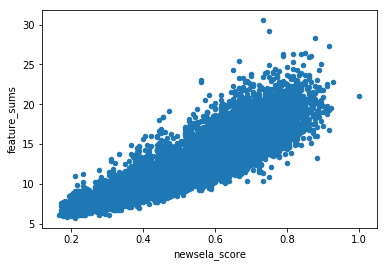

In [85]:
norm_df.plot.scatter(x="newsela_score",y="feature_sums")

In [86]:
norm_df.loc[norm_df["feature_sums"] > 30]

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
1443,data/newsela/dog-brain-scan-21214-1320.txt,dog-brain-scan,21214,0.733333,0.887235,0.981307,1.076477,0.864928,0.94151,0.843771,...,1.820564,0.938436,0.400569,0.923324,11.325217,0.819879,0.487704,0.673113,0.918744,30.524416


## Apply Regression Model

* RidgeCV

In [87]:
norm_df = pd.read_csv("data/newsela_article_features.csv",sep=";")
norm_df["newsela_score"] = norm_df["newsela_score"].astype(float)

In [16]:
#feature_cols = norm_df.columns[2:-1]

In [109]:
def train_eval_model(train,test,model_fn):
    model = model_fn()
    
    feature_cols = list(train.columns)
    feature_cols.remove("newsela_score")
    
    model.fit(train[feature_cols],train["newsela_score"])
    
    print("Evaluation: \n Feature Importance:")
        
    for row in zip(*[train.columns,model.coef_]):
        print(row)
    print("Train Accuracy: ")
    print(model.score(train[feature_cols],
                    train["newsela_score"]))
    print("Test Accuracy: ")
    print(model.score(test[feature_cols],
                    test["newsela_score"]))
    
    return model

In [106]:
def eval_exclude_cols(df,feature_cols,exclude,test,model_fn):
    col_without = feature_cols
    bool_without = [col not in exclude for col in col_without]
    col_without = col_without[bool_without]
    #print(col_without,bool_without)
    train = df[["newsela_score"] + list(col_without)]
    
    return train_eval_model(
        train,test,model_fn)

In [90]:
y_bins = np.digitize(norm_df["newsela_score"], np.linspace(0,1,50))
y_bins[-1] = np.sort(y_bins)[-2]

In [93]:
#Test and Training Set
train,test = train_test_split(
    norm_df[["newsela_score"] + list(ts.feature_names)],
    stratify=y_bins,
    test_size=0.2,
    random_state=0)

R2 Coefficient: 0.9448779963514209


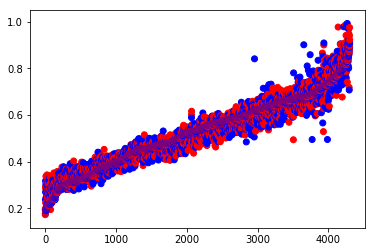

In [97]:
test_sorted = test.sort_values("newsela_score")
model = linear_model.RidgeCV()
model.fit(train[ts.feature_names],train["newsela_score"])
predictions = model.predict(test_sorted[ts.feature_names])
plt.scatter(
    x=[range(len(test)),range(len(test))],
    y=[predictions,test_sorted["newsela_score"]],
    c=["blue","red"])

print(f"R2 Coefficient: {model.score(test[ts.feature_names],test['newsela_score'])}")

In [99]:
model.predict(norm_df.loc[norm_df["name"] == "dog-brain-scan"][ts.feature_names])*1800

array([ 1466.89644616,   618.86304651,   862.92545719,   938.34120161,
        1165.30266586])

In [100]:
norm_df.loc[norm_df["name"] == "dog-brain-scan"]["newsela_score"]*1800

1443     1320.0
2244      550.0
9833      860.0
14546     980.0
18232    1170.0
Name: newsela_score, dtype: float64

### All Attributes

In [101]:
norm_df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,data/newsela/nano-silver-2940-1030.txt,nano-silver,2940,0.572222,1.017097,0.585740,0.862451,0.581339,0.923120,0.680567,...,1.141249,0.462215,0.376654,0.916434,0.0,0.800582,0.611450,0.369207,0.516758,13.005271
1,data/newsela/elem-robot-dog-funeral-japan-4285...,elem-robot-dog-funeral-japan,42851,0.538889,0.915473,0.542635,0.899704,0.508872,0.920312,0.599073,...,0.686613,0.248973,1.545051,0.329759,0.0,0.405435,0.522540,0.450745,0.533986,11.994232
2,data/newsela/public-schools-confederate-names-...,public-schools-confederate-names,34585,0.461111,0.979075,0.453125,0.855771,0.419420,0.845700,0.650504,...,0.675264,0.280312,1.092460,0.377724,0.0,0.430006,0.465536,0.294487,0.267729,9.907067
3,data/newsela/food-waste-6332-490.txt,food-waste,6332,0.272222,0.805600,0.342719,1.222530,0.267769,0.918081,0.381706,...,0.779064,0.123944,0.000000,0.121948,0.0,0.374836,0.966206,0.122240,0.164562,8.457349
4,data/newsela/scotus-jerusalem-10579-720.txt,scotus-jerusalem,10579,0.400000,0.943575,0.414598,1.126991,0.357996,0.696614,0.538879,...,0.858540,0.148174,0.442734,0.396867,0.0,0.557650,0.628881,0.309986,0.217929,9.519286


In [110]:
#RidgeCV
model = eval_exclude_cols(
    train,
    np.array(ts.feature_names),
    [],
    test,
    linear_model.RidgeCV
)

Evaluation: 
 Feature Importance:
('newsela_score', 0.5656214165710729)
('Mean word length', 0.7970394880463938)
('Mean sentence length', -0.11128161961760874)
('Basic english ratio', -0.60724429673682989)
('Syllables per sentence', -0.013912259393822735)
('Type token ratio', 0.093822305472988532)
('#nouns', 0.008127680259323089)
('#verbs', 0.016519740517665027)
('#adjectives', 0.019452103240917173)
('#adverbs', -0.0010751128436927715)
('#pronouns', 0.050647731547570185)
('#commas', 0.064648638270021763)
('Subordination', 0.017821864579204316)
('Complements', 0.052263370674932474)
('Coordination', -0.0043570542929423084)
('Apposition', -0.0038549707917536757)
('Passive verbs', -0.00019929465691248538)
('Parataxis', 0.041526987706365759)
('Auxiliary Verbs', -0.0036688730778529077)
('Negation', 0.080868222469813844)
('Prepositional Phrases', 0.061028404314704687)
Train Accuracy: 
0.946774797024
Test Accuracy: 
0.944877996351


In [111]:
len(test)

4301

### Weebit Data

In [113]:
weebit_df = pd.read_csv("data/weebit_articles_features.csv",sep=";")
weebit_df["regression_score"] = model.predict(weebit_df[ts.feature_names])
weebit_df["feature_sums"] = weebit_df[ts.feature_names].sum(axis=1)

In [114]:
weebit_df["group"] = [row[3] for row in weebit_df["path"].str.split("/")]

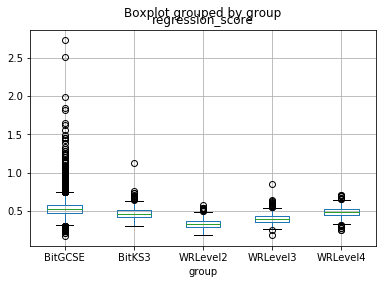

In [132]:
weebit_df.loc[
    (weebit_df["regression_score"] < 10)
].boxplot(column="regression_score",by="group")

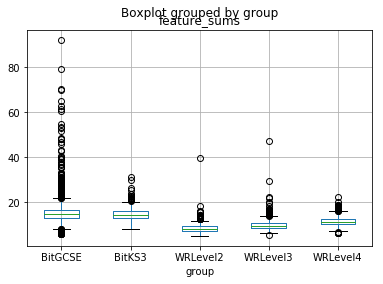

In [135]:
weebit_df.loc[
    #weebit_df["path"].str.contains("WRL") &
    (weebit_df["feature_sums"] < 100)].boxplot(column="feature_sums",by="group")

In [140]:
#which texts have a really high regression score?
high_value_df = weebit_df.loc[
    (weebit_df["regression_score"] > 1.5) &
    (weebit_df["regression_score"] < 2)]

In [142]:
for ind,row in high_value_df.iterrows():
    with open(row["path"],"r") as f:
        print(f.read())

Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Foundation
yourself on Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Higher
Addition, subtraction, multiplication and division - Higher
yourself on Addition, subtraction, multiplication and division - Higher
yourself on Converting fractions, decimals and percentages
yourself on Powers and roots - Foundation
yourself on Powers and roots - Higher

Moniza Alvi: Presents from my Aunts in Pakistan
Moniza Alvi: Presents from my Aunts in Pakistan
on Moniza Alvi: Presents from my Aunts in Pakistan
on Nissim Ezekiel: Night of the Scorpion
yourself on Nissim Ezekiel: Night of the Scorpion
Lawrence Ferlinghetti: Two Scavengers in a Truck...
Lawrence Ferlinghetti: Two Scavengers in a Truck...
on Lawrence Ferlinghetti: Two Scavengers in a Truck...
yourself on Lawrence Ferlinghetti: Two Scavengers in a Truck...
Suj

#### Exclude Articles with a score higher than 1.0

In [160]:
weebit_df = weebit_df.loc[
    (weebit_df["regression_score"] < 1.0)]

## Feature Correlation

### Plot Correlation Matrix

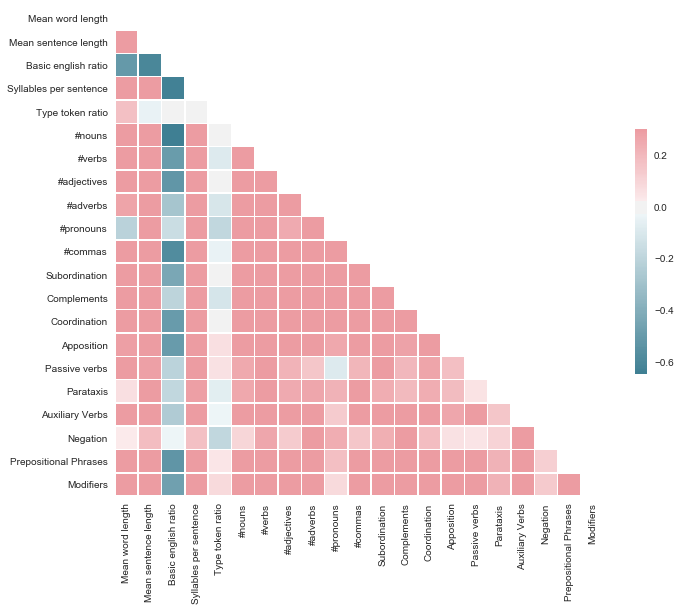

In [143]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = norm_df[ts.feature_names]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Save Scores for each text

In [161]:
final_weebit_df = weebit_df[["path"]+ts.feature_names]
final_newsela_df = norm_df[["path"]+ts.feature_names]


In [162]:
final_newsela_df["dataset"] = "newsela"
final_weebit_df["dataset"] = "weebit"



/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/d062280/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [164]:
dataset_df = pd.concat([final_newsela_df,final_weebit_df])
dataset_df.to_csv("data/dataset.csv",sep=";",index=False)

In [165]:
with open("models/ridgeCV.pkl","wb") as f:
    pickle.dump(model,f)

In [373]:
with open("models/ridgeCV.pkl","rb") as f:
    loaded_model = pickle.load(f)

In [374]:
loaded_model

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)